# Pneumonia Detection

I created a CNN (Convolutional Neural Network) model that detects if a patient has pneumonia or not based on images of chest X-rays. The dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, Input, layers
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import random

Reading in data and creating the training, testing, and validation datasets

In [2]:
def create_datasets(directory):
    labels = ['NORMAL', 'PNEUMONIA']
    images = [];
    diagnosis = [];
    for label in labels:
        path = os.path.join(directory, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            np_img = cv2.imread(img_path)
            np_img = cv2.resize(np_img, (150, 150))
            images.append(np_img)
            diagnosis.append(labels.index(label))
    images = np.array(images)
    diagnosis = np.array(diagnosis)
    return images, diagnosis

In [3]:
X_train, y_train = create_datasets("../Pneumonia Detection/chest_xray/train")
X_test, y_test = create_datasets("../Pneumonia Detection/chest_xray/test")
X_val, y_val = create_datasets("../Pneumonia Detection/chest_xray/val")

Visualizing data

In [4]:
X_train.shape

(5216, 150, 150, 3)

In [5]:
X_test.shape

(624, 150, 150, 3)

In [6]:
def rand_display(X, y):
    rand_index = random.randint(0, X.shape[0]-1)
    img = X[rand_index]
    title = y[rand_index]
    if (title == 0):
        title = 'NORMAL'
    else:
        title = 'PNEUMONIA'    
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

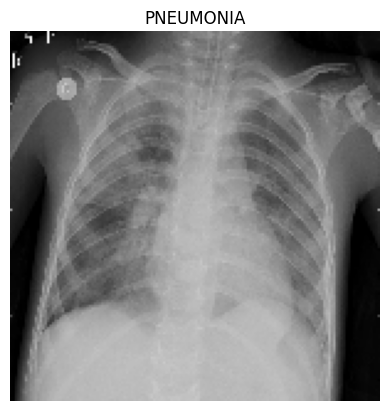

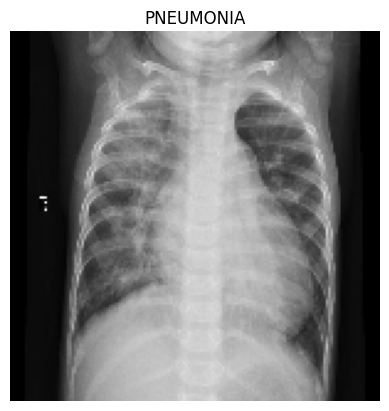

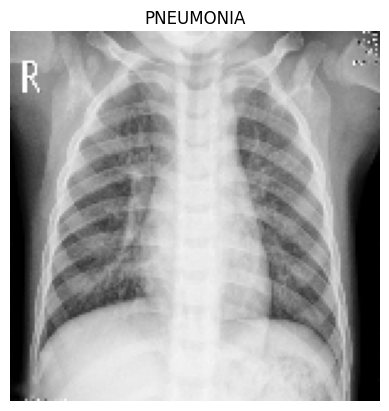

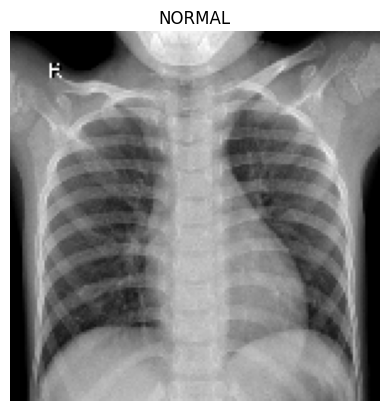

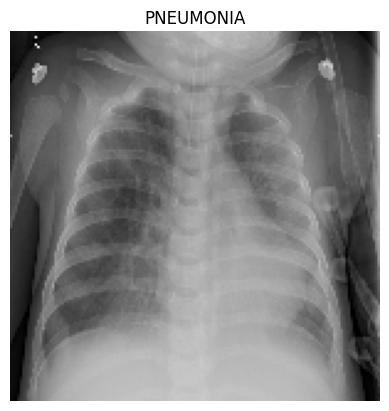

In [7]:
for i in range(5):
    rand_display(X_train, y_train)

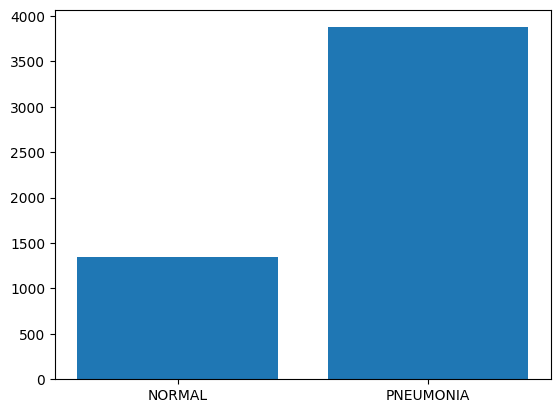

In [8]:
normal_count = np.count_nonzero(y_train == 0)
pneumonia_count = np.count_nonzero(y_train == 1)
plt.bar(["NORMAL", "PNEUMONIA"], [normal_count, pneumonia_count])
plt.show()

Data preprocessing and model creation

In [9]:
X_train = X_train / 255.
X_train = X_train.reshape(-1, 150, 150, 3)

X_test = X_test / 255.
X_test = X_test.reshape(-1, 150, 150, 3)

X_val = X_val / 255.
X_val = X_val.reshape(-1, 150, 150, 3)

Since there are more images for pneumonia, model will likely overfit. Thus, data augmentation needs to be used

In [10]:
data_augmentation = models.Sequential([
    Input(shape=(150, 150, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)
  ])

In [11]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(2, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,367,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,424,194 (9.25 MB)

 Trainable params: 2,424,194 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001)

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - accuracy: 0.7355 - loss: 0.6193 - val_accuracy: 0.5625 - val_loss: 0.7997 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 276ms/step - accuracy: 0.8266 - loss: 0.3460 - val_accuracy: 0.7500 - val_loss: 0.6081 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - accuracy: 0.8728 - loss: 0.2837 - val_accuracy: 0.8125 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.8741 - loss: 0.2839 - val_accuracy: 0.6875 - val_loss: 0.9125 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.8935 - loss: 0.2591 - val_accuracy: 0.6875 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.9035 - loss: 0.2435 - val_accuracy: 0.8750 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.9

Predicting the test dataset's label

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7782 - loss: 0.5027


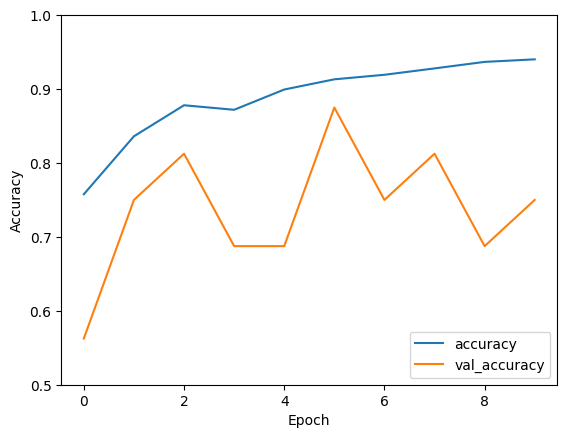

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test)

In [15]:
test_acc

0.8477563858032227

Analyzing the model's predictions

In [16]:
predictions = model.predict(X_test)
predictions = predictions.round()

y_pred = []
for pred in predictions:
    normal_prob = pred[0]
    pneumonia_prob = pred[1]
    if (normal_prob == 1):
        y_pred.append(0)
    else:
        y_pred.append(1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


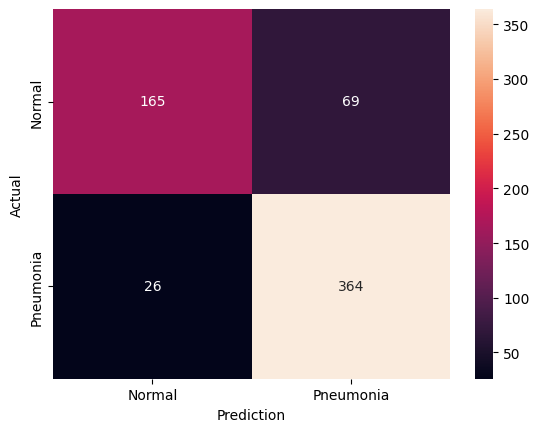

In [17]:
cm = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()